In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from pathlib import Path
import sys
import pickle
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [19]:
repo_dir = Path('../..')

In [20]:
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))
    
from analysis.curve_fitting.src.fitting_functions import LOSS_FUNCTIONS
from analysis.curve_fitting.src.utils import apply_filters, load_yaml, convert_loss_parameters, convert_loss_parameters_batch

from visualization.src.utils import COLOR_PALETTES, set_ticks, save_figs
from visualization.src.visualize import plot_reg, plot_reg_bivariate, plot_confidence_intervals



In [21]:
args = {
    'results_csv': repo_dir / 'results' / 'benchmark_scores_local.csv',
}

In [22]:
results_csv = args['results_csv']

df_results = pd.read_csv(results_csv)
df_results['total_flops'] = df_results['flops'] * df_results['n_samples_seen']

## Load Experiment Configuration

In [23]:
analysis_dir = repo_dir / 'analysis'
config_dir = analysis_dir / 'curve_fitting/configs/model'
results_dir = analysis_dir / 'curve_fitting/fitting_results'

In [24]:
arch_family = [
    'ResNet',
    'EfficientNet',
    'ConvNeXt',
    'ViT'
]

benchmark_types = ['neuro', 'behavior']

In [25]:
all_configs = {}

for arch, b_type in product(arch_family, benchmark_types):
    arch = arch.lower()
    yaml_config = config_dir / f'{arch}/{arch}_{b_type}.yaml'
    all_configs[f"{arch}_{b_type}"] = load_yaml(yaml_config)


In [26]:
L_fit_dict = {key: config['fitting_parameters']['loss_function'] for key, config in all_configs.items()}
L_viz_dict = {key: config['visualization']['loss_function'] for key, config in all_configs.items()}
x_scale_dict = {key: float(config['fitting_parameters']['X_scaler']) for key, config in all_configs.items()}



## Apply Data Filters

In [27]:
all_df = {
    name: apply_filters(df_results, config.get('data_filters', {}))
    for name, config in all_configs.items()
}

## Load Fitting Results

In [28]:
optimized_params_dict = {}
opt_params_boot_dict = {}

for exp_name in all_configs.keys():
    with open(results_dir / f'model_{exp_name}' / 'results.pkl', 'rb') as f:
        results = pickle.load(f)

    L_fit = L_fit_dict[exp_name]
    L_viz = L_viz_dict[exp_name]
    optimized_params_dict[exp_name] = convert_loss_parameters(results['optimized_parameters'], L_fit, L_viz)

    # Convert bootstrapped parameters
    opt_params_boot = results['optimized_parameters_bootstrapped']
    opt_params_boot_dict[exp_name] = convert_loss_parameters_batch(
        params=opt_params_boot,
        src_loss=L_fit,
        dst_loss=L_viz
    )

/Users/akgokce/Documents/brain/scaling-primate-vvs/visualization/fig2/../../analysis/curve_fitting/src/utils/fitting.py:163: RuntimeWarning: overflow encountered in exp
  E, A = np.exp(e), np.exp(a)


In [29]:
results['optimized_parameters']

[-87.67919197, 1.07954809, 3.79525834, 0.12572477]

In [30]:
convert_loss_parameters(results['optimized_parameters'], L_fit, L_viz)

(8.344700416990047e-39, 2.9433491215694407, 3.79525834, -0.12572477)

## Visualize

#### Plotting settings

In [31]:


x_extend = 10
X_str = r'$$\tilde{C}$$'
linewidth = 3.0
alpha_scatter = 0.2
percentile_ci = 95
# percentile_ci = 70
alpha_ci = 0.2
alpha_fit = 1.0
fig_multiplier = 0.75
figsize = (15, 12)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])

color_palaette = COLOR_PALETTES['regions']
color_1, color_2 = color_palaette[0], color_palaette[-1]

#### Plot

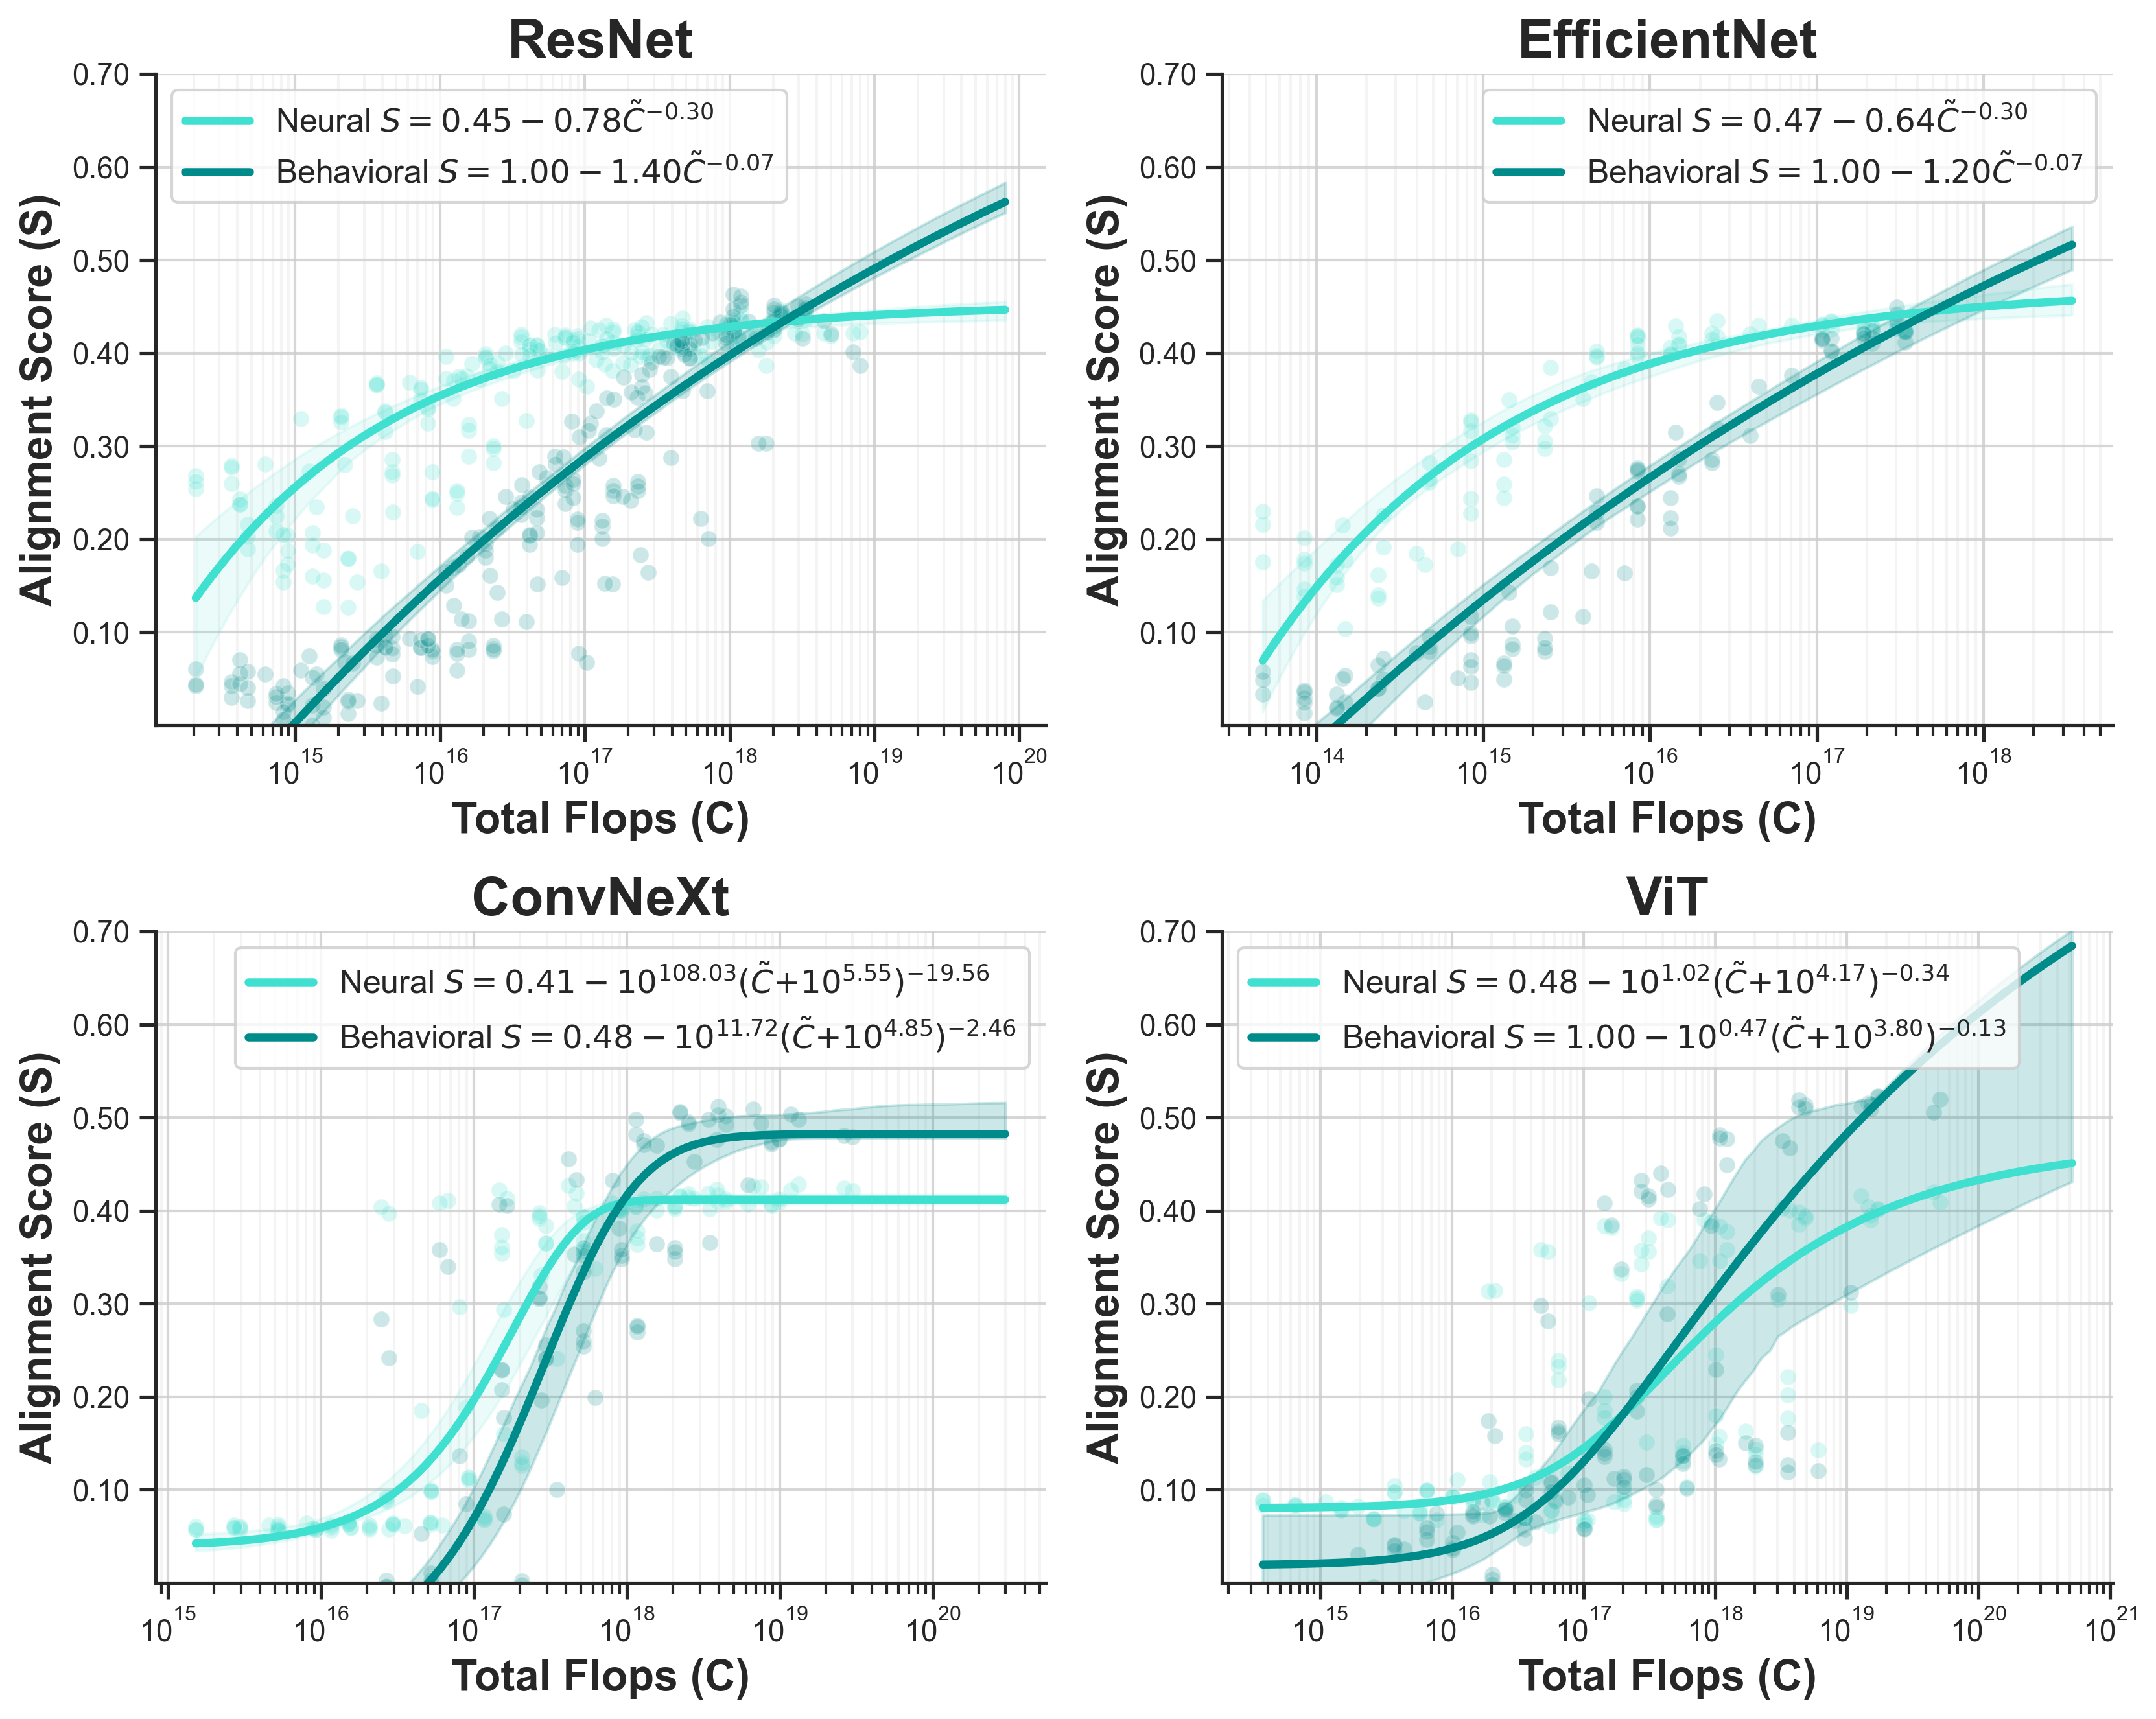

In [32]:

sns.set_theme(style='whitegrid')
sns.set_theme(style='ticks')


fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=300)
for idx, arch in enumerate(arch_family):
    ax = axes.flatten()[idx]

    ### Neuro
    exp_name = f'{arch.lower()}_neuro'
    df_region = all_df[exp_name]
    optimized_params_neuro = optimized_params_dict[exp_name]
    opt_params_boot_neuro = opt_params_boot_dict[exp_name]
    L = LOSS_FUNCTIONS[L_viz_dict[exp_name]]
    x_scaler = x_scale_dict[exp_name]
    X = df_region.total_flops.values / x_scaler
    
    color = color_1
    sns.scatterplot(data=df_region, x='total_flops', y='score', ax=ax, color=color, alpha=alpha_scatter)
    plot_reg(X, optimized_params_neuro, L, ax, color=color, x_extend=x_extend, linestyle='-', X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth, legend=False, alpha=alpha_fit)
    plot_confidence_intervals(X, opt_params_boot_neuro, L, ax, color=color, x_scaler=x_scaler, x_extend=x_extend, alpha=0.1, percentile=percentile_ci, invert_y=True)

    ### Behavioral
    exp_name = f'{arch.lower()}_behavior'
    df_region = all_df[exp_name]
    optimized_params_behavior = optimized_params_dict[exp_name]
    opt_params_boot_behavior = opt_params_boot_dict[exp_name]
    L = LOSS_FUNCTIONS[L_viz_dict[exp_name]]
    x_scaler = x_scale_dict[exp_name]
    X = df_region.total_flops.values / x_scaler
    
    
    color = color_2
    sns.scatterplot(data=df_region, x='total_flops', y='score', ax=ax, color=color, alpha=alpha_scatter)
    plot_reg(X, optimized_params_behavior, L, ax, color=color, x_extend=x_extend, linestyle='-', X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth, legend=False, alpha=alpha_fit)
    plot_confidence_intervals(X, opt_params_boot_behavior, L, ax, color=color, x_scaler=x_scaler, x_extend=x_extend, alpha=alpha_ci, percentile=percentile_ci, invert_y=True)


    ### Formatting
    ax.set_xscale('log')
    ax.set_ylim(0, 0.5)
    ax.set_xlabel('FLOPs')
    ax.set_ylabel('Alignment')
    ax.set_xlabel('Total Flops (C)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Alignment Score (S)', fontsize=16, fontweight='bold')
    ax.set_title(arch, fontsize=20, fontweight='bold')
    ax = set_ticks(ax, xticks_mode='log', yticks_mode=None, yticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

    ### Legend
    handles, labels = ax.get_legend_handles_labels()
    labels = [
        'Neural ' + labels[0],
        'Behavioral '  + labels[1]
    ]
    ax.legend(handles, labels, fontsize=12)

    ax.spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()


figures_dir = '../figures'
fig_name = 'fig2_compute_arch'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)
